# I need to duplicate the fragility table a bunch of times for the training 

# File Description

This notebook contains the most up-to-date version of the pilot model for total water level on Tarawa, currently for only two locations (one hazards side and one ocean side).

Currently needs work:
- Incorporating MEI into network
- Adjusting the binning of the MSL distributions to account for future SLR
- Adding SLR projections as evidence option

# File Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import itertools
import os
import json
from datetime import datetime
import pysmile
import pysmile_license
import sys
import json
sys.path.append('/src/python_classes')
import rpy2
# os.environ['R_HOME'] = 'C:\ProgramData\Anaconda3\Lib\R'
# %load_ext rpy2.ipython
!jupyter nbextension enable --py --sys-prefix ipyleaflet
from ipywidgets import interact, interactive, fixed, interact_manual
from ipyleaflet import *
import ipywidgets as widgets
from matplotlib.animation import FuncAnimation
import geojson
import folium
from colormap import rgb2hex
import rpy2
os.environ['R_HOME'] = '/lib/R'
%load_ext rpy2.ipython
from folium.plugins import FloatImage
from collections import ChainMap
import re

from BNModel import BNModel


Enabling notebook extension jupyter-leaflet/extension...
      - Validating: OK


/usr/local/lib/python3.8/dist-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.8/dist-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/usr/local/lib/python3.8/dist-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.8/dist-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


# Load Hazard Bins

In [3]:
with open("bin_definitions.json") as f:
    bin_defs_dict = json.load(f)

In [4]:
bin_defs_dict

{'earthquake': {'minimum': -5.553142870956083,
  'low': -3.266348397163859,
  'medium': -0.9795539233716353,
  'high': 1.3072405504205884},
 'liquefaction': {'zero': 0.0,
  'low': 7.377941176470587,
  'medium': 14.755882352941175,
  'high': 22.133823529411764},
 'tsunami': {'zero': 0,
  'low': 2.453279318446375,
  'medium': 4.90655863689275,
  'high': 7.359837955339124}}

# Methods for combining DS

In [5]:
damage_states_array = np.array((0,1,2,3,4))
landslide_states_array = np.array((0,4))

fragility_array = np.array(('Shaking','Tsunami','Landslide'))

In [6]:
rows = list(itertools.product(list(itertools.product(damage_states_array,damage_states_array)),landslide_states_array))

df_fragilities = pd.DataFrame.from_dict(dict(ChainMap(*[{i:{
    'Shaking':x[0][0],
    'Tsunami':x[0][1],
    'Landslide':x[1]}} for i,x in zip(np.arange(0,len(rows),1),rows)]))).T

#### But we can put in percentages.. it doesn't have to be 100% into the one state ####

# Rules:
# Pick the max damage state. Start with this as the combined damage state.
# If there are multiple hazards of the same damage state, add one to the combined damage state
# Cap the damage state at 3

for index,row in df_fragilities.iterrows():
    comb_frag = np.max(row)
    # See how many hazards have the max damage state:
    number_with_max_damage = list(row).count(comb_frag)
#     # If there are more than 2, add one to the combined damage state (unless your at max or no damage)
#     if (number_with_max_damage>=2)&(comb_frag!=3)&(comb_frag!=0):
#         comb_frag+=1
    
    # Add to the fragility
    df_fragilities.loc[index,'Combined'] = int(comb_frag)
    
# Rename the columns to include fragility
[df_fragilities.rename(columns={x:x+'Fragility'},inplace=True) for x in df_fragilities if x!='Combined']
    

[None, None, None]

In [7]:
# Replace the integers with strings 
df_fragilities = df_fragilities.replace(0,'DS0')
df_fragilities = df_fragilities.replace(1,'DS1')
df_fragilities = df_fragilities.replace(2,'DS2')
df_fragilities = df_fragilities.replace(3,'DS3')
df_fragilities = df_fragilities.replace(4,'DS4')


In [8]:
df_fragilities.reset_index(drop=True,inplace=True)
df_fragilities

,ShakingFragility,TsunamiFragility,LandslideFragility,Combined
0,DS4,DS4,DS4,DS4
1,DS4,DS4,DS0,DS4
2,DS4,DS3,DS4,DS4
3,DS4,DS3,DS0,DS4
4,DS4,DS2,DS4,DS4
5,DS4,DS2,DS0,DS4
6,DS4,DS1,DS4,DS4
7,DS4,DS1,DS0,DS4
8,DS4,DS0,DS4,DS4
9,DS4,DS0,DS0,DS4


In [9]:
pga_general = np.arange(0,5,1)
PGA1 = pga_general
PGA2 = pga_general
PGA3 = pga_general
LSA = np.arange(0,3,1)

rows = list(itertools.product(list(itertools.product(list(itertools.product(PGA1,PGA2)),PGA3)),LSA))

df_pga_cpt = pd.DataFrame.from_dict(dict(ChainMap(*[{i:{
    'ShakingFragilityA':x[0][0][0],
    'ShakingFragilityB':x[0][0][1],
    'ShakingFragilityC':x[0][1],
    'LiquefactionFragility':x[1]}} for i,x in zip(np.arange(0,len(rows),1),rows)]))).T
    
df_pga_cpt.loc[df_pga_cpt.LiquefactionFragility==0,'ShakingFragility'] = df_pga_cpt.loc[df_pga_cpt.LiquefactionFragility==0,'ShakingFragilityA']
df_pga_cpt.loc[df_pga_cpt.LiquefactionFragility==1,'ShakingFragility'] = df_pga_cpt.loc[df_pga_cpt.LiquefactionFragility==1,'ShakingFragilityB']
df_pga_cpt.loc[df_pga_cpt.LiquefactionFragility==2,'ShakingFragility'] = df_pga_cpt.loc[df_pga_cpt.LiquefactionFragility==2,'ShakingFragilityC']

# df_pga_cpt.loc[df_pga_cpt.PGAt==0]
# df_pga_cpt.loc[df_pga_cpt.PGAt==1]
# df_pga_cpt.loc[df_pga_cpt.PGAt==2]
# df_pga_cpt.loc[df_pga_cpt.PGAt==3]
# df_pga_cpt.loc[df_pga_cpt.PGAt==4]

df_pga_cpt = df_pga_cpt.replace(0,'DS0')
df_pga_cpt = df_pga_cpt.replace(1,'DS1')
df_pga_cpt = df_pga_cpt.replace(2,'DS2')
df_pga_cpt = df_pga_cpt.replace(3,'DS3')
df_pga_cpt = df_pga_cpt.replace(4,'DS4')

df_pga_cpt

,ShakingFragilityA,ShakingFragilityB,ShakingFragilityC,LiquefactionFragility,ShakingFragility
374,DS4,DS4,DS4,DS2,DS4
373,DS4,DS4,DS4,DS1,DS4
372,DS4,DS4,DS4,DS0,DS4
371,DS4,DS4,DS3,DS2,DS3
370,DS4,DS4,DS3,DS1,DS4
...,...,...,...,...,...
4,DS0,DS0,DS1,DS1,DS0
3,DS0,DS0,DS1,DS0,DS0
2,DS0,DS0,DS0,DS2,DS0
1,DS0,DS0,DS0,DS1,DS0


In [10]:
index

0

In [11]:


for index,row in df_fragilities.iterrows():
    df = df_pga_cpt[df_pga_cpt.ShakingFragility==row.ShakingFragility]
    df2 = pd.DataFrame([row]*len(df)).merge(df,left_on='ShakingFragility',right_on='ShakingFragility')
    if index!=0:
        df3 = df3.append(df2)
    else:
        df3 = df2.copy()

In [12]:
df_fragilities = df3

In [13]:
df_fragilities

,ShakingFragility,TsunamiFragility,LandslideFragility,Combined,ShakingFragilityA,ShakingFragilityB,ShakingFragilityC,LiquefactionFragility
0,DS4,DS4,DS4,DS4,DS4,DS4,DS4,DS2
1,DS4,DS4,DS4,DS4,DS4,DS4,DS4,DS1
2,DS4,DS4,DS4,DS4,DS4,DS4,DS4,DS0
3,DS4,DS4,DS4,DS4,DS4,DS4,DS3,DS1
4,DS4,DS4,DS4,DS4,DS4,DS4,DS3,DS0
...,...,...,...,...,...,...,...,...
5620,DS0,DS0,DS0,DS0,DS0,DS0,DS1,DS1
5621,DS0,DS0,DS0,DS0,DS0,DS0,DS1,DS0
5622,DS0,DS0,DS0,DS0,DS0,DS0,DS0,DS2
5623,DS0,DS0,DS0,DS0,DS0,DS0,DS0,DS1


In [61]:
df_fragilities[['ShakingFragilityA','ShakingFragilityB','ShakingFragilityC','LiquefactionFragility','ShakingFragility']].loc[100]

,ShakingFragilityA,ShakingFragilityB,ShakingFragilityC,LiquefactionFragility,ShakingFragility
100,DS4,DS1,DS3,DS0,DS4
100,DS4,DS1,DS3,DS0,DS4
100,DS4,DS1,DS3,DS0,DS4
100,DS4,DS1,DS3,DS0,DS4
100,DS4,DS1,DS3,DS0,DS4
100,DS4,DS1,DS3,DS0,DS4
100,DS4,DS1,DS3,DS0,DS4
100,DS4,DS1,DS3,DS0,DS4
100,DS4,DS1,DS3,DS0,DS4
100,DS4,DS1,DS3,DS0,DS4


# Create a BN using this table

In [14]:
frag_data_dict = {k:np.array(df_fragilities[k]) for k in list(df_fragilities)}

In [15]:
frag_data_dict

{'ShakingFragility': array(['DS4', 'DS4', 'DS4', ..., 'DS0', 'DS0', 'DS0'], dtype=object),
 'TsunamiFragility': array(['DS4', 'DS4', 'DS4', ..., 'DS0', 'DS0', 'DS0'], dtype=object),
 'LandslideFragility': array(['DS4', 'DS4', 'DS4', ..., 'DS0', 'DS0', 'DS0'], dtype=object),
 'Combined': array(['DS4', 'DS4', 'DS4', ..., 'DS0', 'DS0', 'DS0'], dtype=object),
 'ShakingFragilityA': array(['DS4', 'DS4', 'DS4', ..., 'DS0', 'DS0', 'DS0'], dtype=object),
 'ShakingFragilityB': array(['DS4', 'DS4', 'DS4', ..., 'DS0', 'DS0', 'DS0'], dtype=object),
 'ShakingFragilityC': array(['DS4', 'DS4', 'DS4', ..., 'DS0', 'DS0', 'DS0'], dtype=object),
 'LiquefactionFragility': array(['DS2', 'DS1', 'DS0', ..., 'DS2', 'DS1', 'DS0'], dtype=object)}

In [16]:
frag_file_label = 'fragility'

#### Don't include spaces in bin names. if no discretisation, just leave out that key
frag_model_dict = {
    'variables':{
        'ShakingFragilityA':{
            'label':'ShakingFragilityA',
            'child_nodes':['ShakingFragility'],
            'bins':['DS0','DS1','DS2','DS3','DS4']
        },
        'ShakingFragilityB':{
            'label':'ShakingFragilityB',
            'child_nodes':['ShakingFragility'],
            'bins':['DS0','DS1','DS2','DS3','DS4']
        },
        'ShakingFragilityC':{
            'label':'ShakingFragilityC',
            'child_nodes':['ShakingFragility'],
            'bins':['DS0','DS1','DS2','DS3','DS4']
        },
        'LiquefactionFragility':{
            'label':'LiquefactionFragility',
            'child_nodes':['ShakingFragility'],
            'bins':['DS0','DS1','DS2']
        },
        'ShakingFragility':{
            'label':'ShakingFragility',
            'child_nodes':['Combined'],
            'bins':['DS0','DS1','DS2','DS3','DS4']
        },
        'TsunamiFragility':{
            'label':'TsunamiFragility',
            'child_nodes':['Combined'],
            'bins':['DS0','DS1','DS2','DS3','DS4']
        },
        'LandslideFragility':{
            'label':'LandslideFragility',
            'child_nodes':['Combined'],
            'bins':['DS0','DS1','DS2','DS3','DS4']
        },
        'Combined':{
            'label':'Combined',
            'child_nodes':[],
            'bins':['DS0','DS1','DS2','DS3','DS4']
        }
    },
    'training_frac':0.8,
    'bootstrap_reps':1
}

In [17]:
frag_model_dict = BNModel().bootstrap_data(frag_model_dict,frag_data_dict,df_fragilities)

In [18]:
frag_model_dict = BNModel().discretiser(frag_model_dict,[])

ShakingFragilityA
ShakingFragilityB
ShakingFragilityC
LiquefactionFragility
ShakingFragility
TsunamiFragility
LandslideFragility
Combined


In [19]:
BNModel().save_dataset(frag_model_dict,frag_file_label)

In [20]:
frag_model_dict = BNModel().create_SM(frag_model_dict,frag_file_label)

In [21]:
# Set evidence and get beliefs
frag_model_dict = BNModel().update_evidence(frag_model_dict)

# Creating Dummy fragility functions

## Earthquakes

In [22]:
earthquake_bins = {
    'low':0.5001, #0-0.25
    'medium':0.7001, #0.25-0.75
    'high':4.0001 #>.75
}

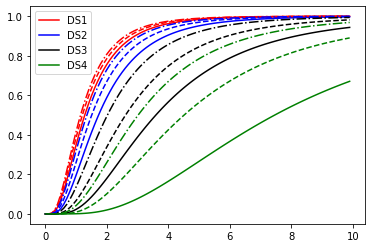

In [23]:
ax = plt.subplot2grid((1,1),(0,0))

# Get max mean pga
mu_ds1 = 0.25#bins['minimum']
mu_ds2 = 0.55#2*earthquake_diff+bins['minimum']
mu_ds3 = 1.28#3*earthquake_diff+bins['minimum']
mu_ds4 = 2.01#4*earthquake_diff+bins['minimum']

sigma_ds1 = 0.64#0.00000001
sigma_ds2 = 0.64#1
sigma_ds3 = 0.64#1
sigma_ds4 = 0.64#1

IM = IM = np.arange(0.0001,10,0.1)#np.arange(bins['minimum'],earthquake_max,(earthquake_max-bins['minimum'])/1000)

from scipy.stats import lognorm
import math

# P_ds1 = [lognorm(s=sigma_ds1).cdf(im)*mu_ds1/lognorm(s=sigma_ds1).mean() for im in IM]
# P_ds2 = [lognorm(s=sigma_ds2).cdf(im)*mu_ds2/lognorm(s=sigma_ds2).mean() for im in IM]
# P_ds3 = [lognorm(s=sigma_ds3).cdf(im)*mu_ds3/lognorm(s=sigma_ds3).mean() for im in IM]
# P_ds4 = [lognorm(s=sigma_ds4).cdf(im)*mu_ds4/lognorm(s=sigma_ds4).mean() for im in IM]

P_ds1a = [lognorm(s=sigma_ds1,scale=math.exp(mu_ds1)).cdf(im) for im in IM]
P_ds2a = [lognorm(s=sigma_ds2,scale=math.exp(mu_ds2)).cdf(im) for im in IM]
P_ds3a = [lognorm(s=sigma_ds3,scale=math.exp(mu_ds3)).cdf(im) for im in IM]
P_ds4a = [lognorm(s=sigma_ds4,scale=math.exp(mu_ds4)).cdf(im) for im in IM]

P_ds1b = [lognorm(s=sigma_ds1,scale=math.exp(mu_ds1*.75)).cdf(im) for im in IM]
P_ds2b = [lognorm(s=sigma_ds2,scale=math.exp(mu_ds2*.75)).cdf(im) for im in IM]
P_ds3b = [lognorm(s=sigma_ds3,scale=math.exp(mu_ds3*.75)).cdf(im) for im in IM]
P_ds4b = [lognorm(s=sigma_ds4,scale=math.exp(mu_ds4*.75)).cdf(im) for im in IM]

P_ds1c = [lognorm(s=sigma_ds1,scale=math.exp(mu_ds1*.55)).cdf(im) for im in IM]
P_ds2c = [lognorm(s=sigma_ds2,scale=math.exp(mu_ds2*.55)).cdf(im) for im in IM]
P_ds3c = [lognorm(s=sigma_ds3,scale=math.exp(mu_ds3*.55)).cdf(im) for im in IM]
P_ds4c = [lognorm(s=sigma_ds4,scale=math.exp(mu_ds4*.55)).cdf(im) for im in IM]


l1 = plt.plot(IM,P_ds1a,c='r')
l2 = plt.plot(IM,P_ds2a,c='b')
l3 = plt.plot(IM,P_ds3a,c='k')
l4 = plt.plot(IM,P_ds4a,c='g')

l5 = plt.plot(IM,P_ds1b,ls='--',c='r')
l6 = plt.plot(IM,P_ds2b,ls='--',c='b')
l7 = plt.plot(IM,P_ds3b,ls='--',c='k')
l8 = plt.plot(IM,P_ds4b,ls='--',c='g')

l9 = plt.plot(IM,P_ds1c,ls='-.',c='r')
l10 = plt.plot(IM,P_ds2c,ls='-.',c='b')
l11 = plt.plot(IM,P_ds3c,ls='-.',c='k')
l12 = plt.plot(IM,P_ds4c,ls='-.',c='g')

# ax.plot([bins['low'],bins['low']],[0,1],ls='--',c='k')
# ax.plot([bins['medium'],bins['medium']],[0,1],ls='--',c='k')
# ax.plot([bins['high'],bins['high']],[0,1],ls='--',c='k')

ax.legend(['DS1','DS2','DS3','DS4'])

# plt.plot(IM,P_ds0)
# plt.plot(IM,P_ds1)
# plt.plot(IM,P_ds2)
# plt.plot(IM,P_ds3)


In [24]:
df_ds_shaking_a = pd.DataFrame.from_dict({"DS1":P_ds1a,"DS2":P_ds2a,"DS3":P_ds3a,"DS4":P_ds4a})
df_ds_shaking_a.index = IM

df_ds_shaking_b = pd.DataFrame.from_dict({"DS1":P_ds1b,"DS2":P_ds2b,"DS3":P_ds3b,"DS4":P_ds4b})
df_ds_shaking_b.index = IM

df_ds_shaking_c = pd.DataFrame.from_dict({"DS1":P_ds1c,"DS2":P_ds2c,"DS3":P_ds3c,"DS4":P_ds4c})
df_ds_shaking_c.index = IM

In [25]:
def normalise(df_ds_shaking):
    df_ds_shaking["DS3"] = df_ds_shaking.DS3-df_ds_shaking.DS4
    df_ds_shaking["DS2"] = df_ds_shaking.DS2-df_ds_shaking.DS3-df_ds_shaking.DS4
    df_ds_shaking["DS1"] = df_ds_shaking.DS1-df_ds_shaking.DS2-df_ds_shaking.DS3-df_ds_shaking.DS4

    # Now add zero
    ds_shaking_dict = {}

    for index,row in df_ds_shaking.iterrows():
        row['DS0'] = (1-np.sum(row))
        ds_shaking_dict.update({
            index:row
        })

    df_ds_shaking = pd.DataFrame.from_dict(ds_shaking_dict,orient='index')
    
    return(df_ds_shaking)

In [26]:
df_ds_shaking_a = normalise(df_ds_shaking_a)
df_ds_shaking_b = normalise(df_ds_shaking_b)
df_ds_shaking_c = normalise(df_ds_shaking_c)

Text(0, 0.5, 'Prob')

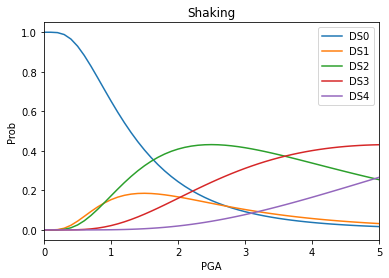

In [27]:
l0 = plt.plot(df_ds_shaking_a.DS0)
l1 = plt.plot(df_ds_shaking_a.DS1)
l2 = plt.plot(df_ds_shaking_a.DS2)
l3 = plt.plot(df_ds_shaking_a.DS3)
l4 = plt.plot(df_ds_shaking_a.DS4)

plt.xlim([0,5])

plt.legend(['DS0','DS1','DS2','DS3','DS4'])
plt.title('Shaking')
plt.xlabel('PGA')
plt.ylabel('Prob')

In [28]:
df_ds_shaking_a = df_ds_shaking_a[['DS0','DS1','DS2','DS3','DS4']]
df_ds_shaking_b = df_ds_shaking_b[['DS0','DS1','DS2','DS3','DS4']]
df_ds_shaking_c = df_ds_shaking_c[['DS0','DS1','DS2','DS3','DS4']]


## Tsunami

In [29]:
tsunami_bins = {
    'zero':0.0001, #0
    'low':0.2001, #<0.2
    'medium':1.5001, #0.2-1
    'high':2.7001 #>1
}

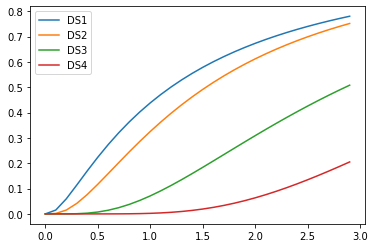

In [30]:
ax = plt.subplot2grid((1,1),(0,0))

# Get max mean pga
mu_ds1 = 0.178#bins['minimum']
mu_ds2 = 0.4255#2*earthquake_diff+bins['minimum']
mu_ds3 = 1.05#3*earthquake_diff+bins['minimum']
mu_ds4 = 1.5#4*earthquake_diff+bins['minimum']

sigma_ds1 = 1.1462#0.00000001
sigma_ds2 = 0.9395#1
sigma_ds3 = 0.7155#1
sigma_ds4 = 0.5288#1

IM = IM = np.arange(0.0001,3,0.1)#np.arange(bins['minimum'],earthquake_max,(earthquake_max-bins['minimum'])/1000)

from scipy.stats import lognorm
import math

P_ds1 = [lognorm(s=sigma_ds1,scale=math.exp(mu_ds1)).cdf(im) for im in IM]
P_ds2 = [lognorm(s=sigma_ds2,scale=math.exp(mu_ds2)).cdf(im) for im in IM]
P_ds3 = [lognorm(s=sigma_ds3,scale=math.exp(mu_ds3)).cdf(im) for im in IM]
P_ds4 = [lognorm(s=sigma_ds4,scale=math.exp(mu_ds4)).cdf(im) for im in IM]


l1 = plt.plot(IM,P_ds1)
l2 = plt.plot(IM,P_ds2)
l3 = plt.plot(IM,P_ds3)
l4 = plt.plot(IM,P_ds4)

# ax.plot([bins['low'],bins['low']],[0,1],ls='--',c='k')
# ax.plot([bins['medium'],bins['medium']],[0,1],ls='--',c='k')
# ax.plot([bins['high'],bins['high']],[0,1],ls='--',c='k')

ax.legend(['DS1','DS2','DS3','DS4'])

# plt.plot(IM,P_ds0)
# plt.plot(IM,P_ds1)
# plt.plot(IM,P_ds2)
# plt.plot(IM,P_ds3)


# Add a rule to stop the crossover

In [31]:
df_ds_tsunami = pd.DataFrame.from_dict({"DS1":P_ds1,"DS2":P_ds2,"DS3":P_ds3,"DS4":P_ds4})
df_ds_tsunami.index = IM

In [32]:
df_ds_tsunami["DS3"] = df_ds_tsunami.DS3-df_ds_tsunami.DS4
df_ds_tsunami["DS2"] = df_ds_tsunami.DS2-df_ds_tsunami.DS3-df_ds_tsunami.DS4
df_ds_tsunami["DS1"] = df_ds_tsunami.DS1-df_ds_tsunami.DS2-df_ds_tsunami.DS3-df_ds_tsunami.DS4

# Now add zero
ds_tsunami_dict = {}

for index,row in df_ds_tsunami.iterrows():
    row['DS0'] = (1-np.sum(row))
    ds_tsunami_dict.update({
        index:row
    })
    
df_ds_tsunami = pd.DataFrame.from_dict(ds_tsunami_dict,orient='index')


Text(0, 0.5, 'Prob')

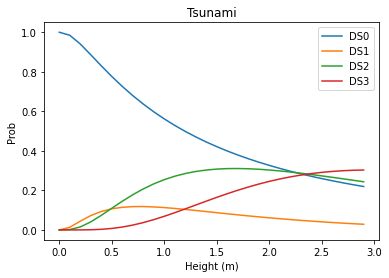

In [33]:
l0 = plt.plot(df_ds_tsunami.DS0)
l1 = plt.plot(df_ds_tsunami.DS1)
l2 = plt.plot(df_ds_tsunami.DS2)
l3 = plt.plot(df_ds_tsunami.DS3)

plt.legend(['DS0','DS1','DS2','DS3'])
plt.title('Tsunami')
plt.xlabel('Height (m)')
plt.ylabel('Prob')

In [34]:
df_ds_tsunami = df_ds_tsunami[['DS0','DS1','DS2','DS3','DS4']]
df_ds_tsunami

,DS0,DS1,DS2,DS3,DS4
0.0001,1.000000,1.297050e-16,5.540854e-25,6.144059e-47,1.636083e-91
0.1001,0.984741,1.340887e-02,1.848406e-03,1.404889e-06,3.261463e-13
0.2001,0.940503,4.432022e-02,1.507559e-02,1.011204e-04,2.060868e-09
0.3001,0.885977,7.256812e-02,4.063757e-02,8.169182e-04,1.587236e-07
0.4001,0.830083,9.326096e-02,7.365596e-02,2.997508e-03,2.451311e-06
0.5001,0.776330,1.067395e-01,1.095051e-01,7.408811e-03,1.684111e-05
0.6001,0.726020,1.144629e-01,1.449335e-01,1.451210e-02,7.167800e-05
0.7001,0.679518,1.178880e-01,1.779332e-01,2.443733e-02,2.233467e-04
0.8001,0.636781,1.182100e-01,2.074055e-01,3.704308e-02,5.602990e-04
0.9001,0.597592,1.163460e-01,2.328633e-01,5.199810e-02,1.200106e-03


## Liquefaction

In [35]:
liquefaction_bins = {
    'low':0, #<0.2
    'medium':1, #0.2-1
    'high':2 #>1
}


## Landslide

In [36]:
# It's binary, so just make up two rows
ds_landslide_dict = {
    '0':{
        'DS0':1.0,
        'DS1':0.0,
        'DS2':0.0,
        'DS3':0.0,
        'DS4':0.0
    },
    '1':{
        'DS0':0.0,
        'DS1':0.0,
        'DS2':0.0,
        'DS3':0.0,
        'DS4':1.0
    }
}

In [37]:
df_ds_landslide = pd.DataFrame.from_dict(ds_landslide_dict,orient='index')

## Find the prior distribution for this hazard

## Define Low, Medium and High

In [38]:
# ## Make up the definition of low, medium and high
# len_pga = len(list(df_ds_shaking.index))
# pga_low = list(df_ds_shaking.index)[int((len_pga-1)/4)]
# pga_medium = list(df_ds_shaking.index)[int(2*(len_pga-1)/4)]
# pga_high = list(df_ds_shaking.index)[int(3*(len_pga-1)/4)]


In [39]:
earthquake_bins['medium']

0.7001

In [40]:
min(list(df_ds_shaking_b.index), key=lambda x:abs(x-earthquake_bins['medium']))

0.7001000000000001

In [41]:
earthquake_low = min(list(df_ds_shaking_a.index), key=lambda x:abs(x-earthquake_bins['low']))
earthquake_medium = min(list(df_ds_shaking_a.index), key=lambda x:abs(x-earthquake_bins['medium']))
earthquake_high = min(list(df_ds_shaking_a.index), key=lambda x:abs(x-earthquake_bins['high']))

liquefaction_low = liquefaction_bins['low']
liquefaction_medium = liquefaction_bins['medium']
liquefaction_high = liquefaction_bins['high']

tsunami_zero = min(list(df_ds_tsunami.index), key=lambda x:abs(x-tsunami_bins['zero']))
tsunami_low = min(list(df_ds_tsunami.index), key=lambda x:abs(x-tsunami_bins['low']))
tsunami_medium = min(list(df_ds_tsunami.index), key=lambda x:abs(x-tsunami_bins['medium']))
tsunami_high = min(list(df_ds_tsunami.index), key=lambda x:abs(x-tsunami_bins['high']))

landslide_no = '0'
landslide_yes = '1'


# Set Conditional Prob Tables

In [42]:
frag_model_dict_copy = frag_model_dict.copy()
net = frag_model_dict_copy['model'][0]['net']

In [43]:
net.write_file("BN_simple.xdsl")

In [44]:
list_of_nodes = net.get_all_nodes()
# # list_of_nodes.pop(net.get_node('Combined'))
# # list_of_nodes.pop(net.get_node('ShakingFragility'))
# # list_of_nodes.pop(net.get_node('ShakingFragilityA'))
# # list_of_nodes.pop(net.get_node('ShakingFragilityB'))
# # list_of_nodes.pop(net.get_node('ShakingFragilityC'))
[ net.get_node_id(x) for x in list_of_nodes]

['ShakingFragilityA',
 'ShakingFragilityB',
 'ShakingFragilityC',
 'LiquefactionFragility',
 'ShakingFragility',
 'TsunamiFragility',
 'LandslideFragility',
 'Combined']

In [45]:
# for node_handle in list_of_nodes:
#     # Get a single fragility node
#     child_node_name = net.get_node_id(node_handle)
    
#     print(child_node_name)

In [46]:
child_node_names = ['LiquefactionFragility','LandslideFragility','TsunamiFragility']

In [47]:
for child_node_name in child_node_names:
    # Get a single fragility node
#     child_node_name = net.get_node_id(node_handle)
    # Create a new node for the hazard
    new_node_name = re.sub('Fragility','',child_node_name)
    net.add_node(pysmile.NodeType.CPT,new_node_name)
    # Add the outcomes
#     if (new_node_name=='ShakingA')|(new_node_name=='ShakingB')|(new_node_name=='ShakingC'):
#         outcomes = ['low','medium','high']
    if new_node_name=='Landslide':
        outcomes = ['no','yes']
    elif new_node_name=='Tsunami':
        outcomes = ['zero','low','medium','high']
    elif new_node_name=='Liquefaction':
        outcomes = ['low','medium','high']
    for outcome in outcomes:
        net.add_outcome(new_node_name,outcome)
    # Delete the premade states
    net.delete_outcome(new_node_name,'State0')
    net.delete_outcome(new_node_name,'State1')
    # Create connection between the hazard and fragility functions
    
    net.add_arc(new_node_name,child_node_name)
    print(new_node_name)
    print(child_node_name)
    # Set the values of the conditional probability table for the fragility node
    if new_node_name=='Landslide':
        cpt_value = \
            list(df_ds_landslide[df_ds_landslide.index==landslide_no].T[landslide_no])+\
            list(df_ds_landslide[df_ds_landslide.index==landslide_yes].T[landslide_yes])
    elif new_node_name=='Tsunami':
        cpt_value = \
            list(df_ds_tsunami[df_ds_tsunami.index==tsunami_zero].T[tsunami_zero])+\
            list(df_ds_tsunami[df_ds_tsunami.index==tsunami_low].T[tsunami_low])+\
            list(df_ds_tsunami[df_ds_tsunami.index==tsunami_medium].T[tsunami_medium])+\
            list(df_ds_tsunami[df_ds_tsunami.index==tsunami_high].T[tsunami_high])
    elif new_node_name=='Liquefaction':
        cpt_value = [1,0,0,0,1,0,0,0,1]
    net.set_node_definition(child_node_name,cpt_value)
    net.set_node_definition(new_node_name,[1/len(outcomes)]*len(outcomes))

Liquefaction
LiquefactionFragility
Landslide
LandslideFragility
Tsunami
TsunamiFragility


In [48]:

# Get a single fragility node
# child_node_name = net.get_node_id(node_handle)
# Create a new node for the hazard
new_node_name = 'Shaking'

net.add_node(pysmile.NodeType.CPT,new_node_name)

outcomes = ['low','medium','high']

for outcome in outcomes:
    net.add_outcome(new_node_name,outcome)
# Delete the premade states
net.delete_outcome(new_node_name,'State0')
net.delete_outcome(new_node_name,'State1')
# Create connection between the hazard and fragility functions

for node in ['ShakingFragilityA','ShakingFragilityB','ShakingFragilityC']:
    net.add_arc(new_node_name,node)

# Set the values of the conditional probability table for the fragility node
cpt_value = \
    list(df_ds_shaking_a[df_ds_shaking_a.index==earthquake_low].T[earthquake_low])+\
    list(df_ds_shaking_a[df_ds_shaking_a.index==earthquake_medium].T[earthquake_medium])+\
    list(df_ds_shaking_a[df_ds_shaking_a.index==earthquake_high].T[earthquake_high])

for node in ['ShakingFragilityA','ShakingFragilityB','ShakingFragilityC']:
    net.set_node_definition(node,cpt_value)

net.set_node_definition(new_node_name,[1/len(outcomes)]*len(outcomes))

In [49]:
net.write_file("test.xdsl")
frag_model_dict['model'][0].update({
    'net':net
})


In [50]:
net.write_file("testBN.xdsl")

In [51]:
frag_model_dict['variables'].update({
        'Shaking':{
            'label':'Shaking',
            'child_nodes':['ShakingFragility'],
            'bins':['low','medium','high']
        },
        'Tsunami':{
            'label':'Tsunami',
            'child_nodes':['TsunamiFragility'],
            'bins':['zero','low','medium','high']
        },
        'Landslide':{
            'label':'Landslide',
            'child_nodes':['LandslideFragility'],
            'bins':['no','yes']
        }
})

In [52]:
# Add hazard evidence to dict
hazards_evidence_dict = {
    'Landslide':[1,0],
    'Tsunami':[0,1,0,0],
    'Shaking':[1,0,0]
}
frag_model_dict = BNModel().add_evidence_to_dict(frag_model_dict,hazards_evidence_dict)

# Set evidence and get beliefs
frag_model_dict = BNModel().update_evidence(frag_model_dict)


# Set Evidence

In [53]:
mean_pga = 0.42482
sigma_pga = 2.1371


In [54]:
frag_model_dict

{'variables': {'ShakingFragilityA': {'label': 'ShakingFragilityA',
   'child_nodes': ['ShakingFragility'],
   'bins': ['DS0', 'DS1', 'DS2', 'DS3', 'DS4'],
   'training_data_preprocessed': {0: array(['DS4', 'DS4', 'DS4', ..., 'DS0', 'DS0', 'DS0'], dtype=object)},
   'testing_data_preprocessed': {0: array([], dtype=object)},
   'training_data': {0: array(['DS4', 'DS4', 'DS4', ..., 'DS0', 'DS0', 'DS0'], dtype=object)},
   'testing_data': {0: array([], dtype=object)},
   'id': 0,
   'resulting_probs': {0: {'DS0': 0.9296723313747892,
     'DS1': 0.04426547350466256,
     'DS2': 0.025036639324750153,
     'DS3': 0.0010135211836105763,
     'DS4': 1.2034612187439764e-05}}},
  'ShakingFragilityB': {'label': 'ShakingFragilityB',
   'child_nodes': ['ShakingFragility'],
   'bins': ['DS0', 'DS1', 'DS2', 'DS3', 'DS4'],
   'training_data_preprocessed': {0: array(['DS4', 'DS4', 'DS4', ..., 'DS0', 'DS0', 'DS0'], dtype=object)},
   'testing_data_preprocessed': {0: array([], dtype=object)},
   'training

# Looping over grid, calculating probs

In [55]:
# Loop over each of the hazards, and get the relevant columns

In [56]:
df_hazards = pd.read_csv('example_data.csv')
hazard_keys = ['_shaking_prob','_liq','_tsunami','_landslide']
hazard_node_names = ['Shaking','Liquefaction','Tsunami','Landslide']

for index,row in df_hazards.iterrows():
    
    # Create evidence dict, one hazard at a time
    hazards_evidence_dict = {}
    for key,node_name in zip(hazard_keys,hazard_node_names):
        hazard_cols = [x for x in df_hazards.columns if key in x]
            
        hazards_evidence_dict.update({
            node_name:list(row[hazard_cols])
        })
        asdf
    # Add hazard evidence to dict
    frag_model_dict = BNModel().add_evidence_to_dict(frag_model_dict,hazards_evidence_dict)
    
    # Set evidence and get beliefs
    frag_model_dict = BNModel().update_evidence(frag_model_dict)
    
    asdf

NameError: name 'asdf' is not defined

In [ ]:
net.get_node_value('Combined')

In [ ]:
dir(net)

In [ ]:
net.get_node_definition('Combined')

In [ ]:
net.get_outcome_ids('Combined')

In [ ]:
# Add hazard evidence to dict
frag_model_dict = BNModel().add_evidence_to_dict(frag_model_dict,hazards_evidence_dict)

# Set evidence and get beliefs
frag_model_dict = BNModel().update_evidence(frag_model_dict)

In [ ]:
hazards_evidence_dict

In [ ]:
net.get_all_node_ids()

In [ ]:
asdfasdf

# Get the cpt for deciding between the PGAs

In [ ]:
PGA1

## Create Definition of bins for each hazard

### Earthquake

# Data Prep

## Preprocessing

In [ ]:
df_hazards = pd.read_csv('example_data.csv')
df_hazards_subset = df_hazards.drop(['lon','lat'],axis=1)
hazards_data_dict = {col:np.array(content) for col,content in df_hazards_subset.iteritems()}

In [ ]:
df_hazards = df_hazards[1:]

In [ ]:
df

## Create Variable Dictionary

In [ ]:
#### Don't include spaces in bin names. if no discretisation, just leave out that key
hazards_model_dict = {
    'variables':{
        'meanpga_lo':{
            'label':'meanpga_lo',
            'discretisation':{
                'n_bins':3,
                'strategy':'kmeans',
                'bin_names':['Low','Mid','High']
            },
            'child_nodes':['Liq_Class','land_LP2500_max']
        },
        'Liq_Class':{
            'label':r'Liq_Class',
            'child_nodes':[],
            'bins':np.unique(df_hazards['Liq_Class'])
        },
        'land_LP2500_max':{
            'label':'land_LP2500_max',
            'discretisation':{
                'n_bins':3,
                'strategy':'kmeans',
                'bin_names':['Low','Mid','High']
            },
            'child_nodes':[]
        }
    },
    'training_frac':0.8,
    'bootstrap_reps':1
}

## Bootstrapping the data

In [ ]:
# Bootstrap the data, and add it to the model_dict
hazards_model_dict = BNModel().bootstrap_data(hazards_model_dict,hazards_data_dict,df_hazards)


In [ ]:
hazards_model_dict['variables'].keys()

## Discretise the data

In [ ]:
# Discretise the data
hazards_file_label = "hazards"

hazards_model_dict = BNModel().discretiser(hazards_model_dict,["Liq_Class"])

In [ ]:
# hazards_disc_fig = BNModel().plot_discretiser(hazards_model_dict,["Liq_Class"])

## Save the data

In [ ]:
BNModel().save_dataset(hazards_model_dict,hazards_file_label)

# Create BN Model

In [ ]:
# Create the BN
hazards_model_dict = BNModel().create_SM(hazards_model_dict,hazards_file_label)

## View Conditional Probability tables

In [ ]:
# Get conditional probs tables
BNModel().get_conditional_prob_table(hazards_model_dict,'land_LP2500_max')

In [ ]:
# # Get conditional probs tables
# df_CPT_MSL = BNModel().get_conditional_prob_table(ocean_model_dict,'TWL')

# df_CPT_MSL = df_CPT_MSL.loc[['VeryLow','Low','Mid','High','VeryHigh']]

# plt.pcolor(df_CPT_MSL)

# Set Evidence

In [ ]:
hazards_evidence_dict = {
    'land_LP2500_max':[0.05,0.1,0.01]
}


In [ ]:
hazards_model_dict = BNModel().add_evidence_to_dict(hazards_model_dict,hazards_evidence_dict)

# Update beliefs based on evidence

In [ ]:
# Set evidence and get beliefs
hazards_model_dict = BNModel().update_evidence(hazards_model_dict)

# BN Visualisation

In [ ]:

# Set up graph
graph_hazards = BNModel().create_BN_graph()

# Create nodes of the graph
graph_hazards,hazards_model_dict = BNModel().create_nodes(graph_hazards,hazards_model_dict,0)

# Create arcs between nodes
graph_hazards = BNModel().create_arcs(graph_hazards,hazards_model_dict)

# Save as dot file
graph_hazards.render(filename='graph_hazards',format='png')

# Plot the graph
graph_hazards
